In [3]:
import numpy as np
import pandas as pd
import seaborn as sns     

import matplotlib.pyplot as plt   
import matplotlib as mpl          
mpl.rc('font', family='Malgun Gothic')     
plt.rcParams['axes.unicode_minus']=False

from scipy import stats
import statsmodels.tsa.api as tsa
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import itertools               # 반복수를 만드는 라이브러리 

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.stats.diagnostic import acorr_ljungbox
from pmdarima import auto_arima

import requests
from io import StringIO
import FinanceDataReader as fdr

# 주가 예측
- 상장 법인 목록에서 종목 코드를 통해 기업주가 다운로드
- 최근 5년간 주식 관련 정보에 대한 시계열 데이터
- 데이터 구조 (1219, 6)
- 소스 참조
    - 법인 상자 가져오기  : https://sguys99.github.io/trading1
- 설치
    - !pip install pandas_datareader
    - !pip install yfinance 

## 데이터 가져오기 

In [12]:
url="http://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13"

response=requests.get(url)
response.encoding="cp949"  
# response.text

# StringIO로 HTML 문자열을 파일처럼 다루기
html_content=StringIO(response.text)   # 문자열을 파일처럼 다룰 수 있는 객체

# pandas에서 HTML 읽기
web_data=pd.read_html(html_content, header=None)[0]  # header=0:컬럼 이름 / [0]:첫 번째 테이블
web_data.shape

(2764, 9)

In [14]:
web_data.head(2)

,회사명,종목코드,업종,주요제품,상장일,결산월,대표자명,홈페이지,지역
0,DSR제강,69730,1차 철강 제조업,"와이어로프,각종 경강선,철선제품,PC강선,아연도 강연선 제조",2003-01-28,12월,"홍하종, 홍석빈 (각자 대표이사)",http://www.dsrcorp.com,전라남도
1,GS글로벌,1250,상품 종합 도매업,"수출입업(시멘트,철강금속,전기전자,섬유,기계화학),상품중개,광업,채석업/하수처리 서...",1976-06-26,12월,이영환,http://www.gsgcorp.com,서울특별시


In [16]:
# 국내 주식시장의 종목코드는 6자리 / 예를 들어 ‘DL’의 종목코드는 000210
# 그런데 저장된 종목코드는 앞자리 0이 생략되어 있다. map함수로 6자리를 완성한다.

web_data['종목코드']=web_data['종목코드'].map('{:06d}'.format)

In [18]:
stock_data=web_data[['회사명', '종목코드']]   # 스톡
stock_data=stock_data.rename(columns={'회사명':'name', '종목코드':'code'})
stock_data.head()

,name,code
0,DSR제강,069730
1,GS글로벌,001250
2,HDC랩스,039570
3,HD한국조선해양,009540
4,HD현대,267250


In [20]:
# 해당 종목의 주식 코드 가져오기 
def get_code(df, name):
    result=df[df['name'] == name]['code']
    if not result.empty:
        return result.values[0]
    else:
        return ''

In [22]:
stock_code=get_code(stock_data, '삼성전자')
stock_code

'005930'

## 데이터 전처리

In [28]:
today=pd.Timestamp.today().strftime('%Y-%m-%d')
today

stock=fdr.DataReader(stock_code,  start='2024-01-01', end=today)   # end 생략시 오늘 날짜
stock.shape

(299, 6)

In [30]:
# 보간법 : 날짜가 비어있는 부분을 보간 (선형 보간법)
stock=stock.asfreq('B', method='pad')    #  B:영업일만고려/자동으로 제외, 'D':모든 날짜/전날데이터로
stock.shape

(322, 6)

- freq: 변경할 빈도 (예: 'D'=일별, 'B'=영업일 기준, 'W'=주별, 'M'=월별 등)
- method: 빈 값이 발생할 경우 보간 방법 ('pad', 'bfill', None)
    - 'pad'(ffill, forward fill): 이전 값을 복사하여 채움
    - 'bfill'(backward fill): 이후 값을 복사하여 채움

In [33]:
stock.to_csv('./Data/supervised/stock.csv')

In [37]:
stock.head()
# stock.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2024-01-02,78200,79800,78200,79600,17142847,0.014013
2024-01-03,78500,78800,77000,77000,21753644,-0.032663
2024-01-04,76100,77300,76100,76600,15324439,-0.005195
2024-01-05,76700,77100,76400,76600,11304316,0.000000
2024-01-08,77000,77500,76400,76500,11088724,-0.001305


In [39]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 322 entries, 2024-01-02 to 2025-03-26
Freq: B
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    322 non-null    int64  
 1   High    322 non-null    int64  
 2   Low     322 non-null    int64  
 3   Close   322 non-null    int64  
 4   Volume  322 non-null    int64  
 5   Change  322 non-null    float64
dtypes: float64(1), int64(5)
memory usage: 17.6 KB


- Close : 장 닫을 때 때 (종가)
- High : 장 중 제일 낮았던 주가(저가)        
- Low  : 장 중 제일 낮았던 주가(고가)            
- Open  : 장 시작 때 (시가)
- Volume : 주식 거래량
- Change : 종가 기준으로 전일 대비 가격 변화 (변동률 또는 변화량)

In [43]:
company=stock[['Close']]
company.head()

,Close
Date,
2024-01-02,79600
2024-01-03,77000
2024-01-04,76600
2024-01-05,76600
2024-01-08,76500


## 시각화

<Axes: xlabel='Date'>

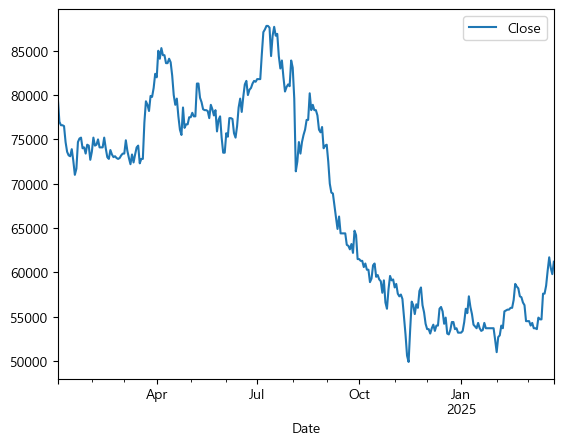

In [46]:
company.plot()

## 시계열 분해
- API : https://www.statsmodels.org/stable/index.html
- 시계열에 영향을 주는 일반적 요인을 시계열에서 분리해 분석하는 방법 

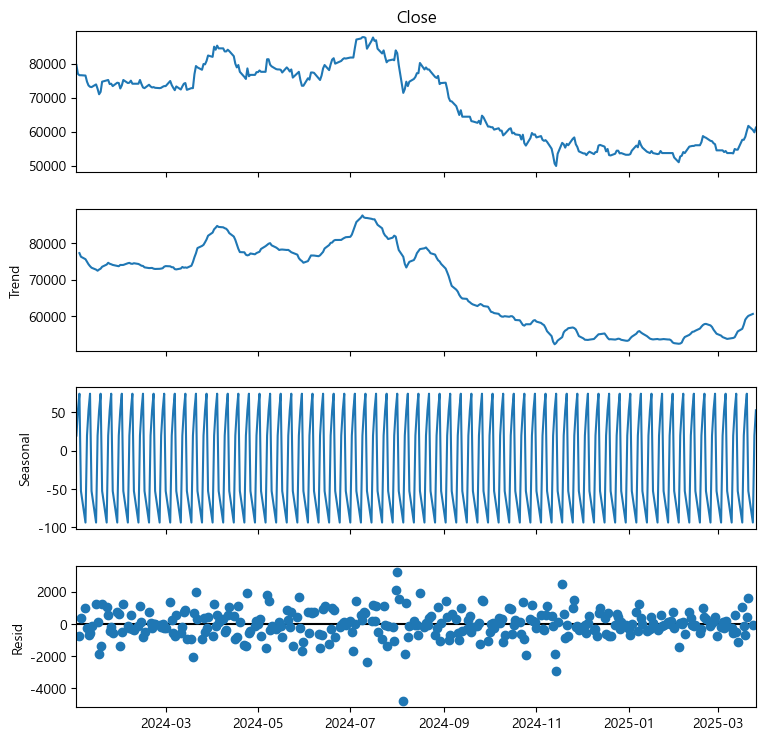

In [49]:
# https://www.statsmodels.org/stable/index.html

decomposetion=tsa.seasonal_decompose(company['Close'], model='additive')    # multiplicative
fig=decomposetion.plot()
fig.set_size_inches(8, 8)
plt.show()

## 정상성 확인

In [81]:
company_train_data, company_test_data=train_test_split(company, test_size=0.05, shuffle=False)
company_train_data.shape, company_test_data.shape

((305, 1), (17, 1))

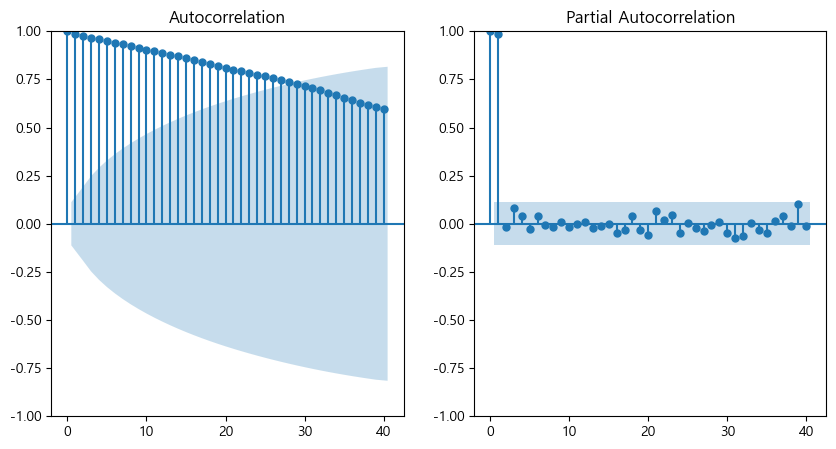

In [83]:
# ACF, PACF 
fig, ax=plt.subplots(1, 2, figsize=(10, 5))
plot_acf(company_train_data.values, lags=40, ax=ax[0])
plot_pacf(company_train_data.values, lags=40, ax=ax[1])
plt.show()

In [85]:
# 차분 - 정상성
company_diff_train_data=company_train_data.copy()
company_diff_train_data=company_diff_train_data['Close'].diff()
company_diff_train_data.dropna(inplace=True)

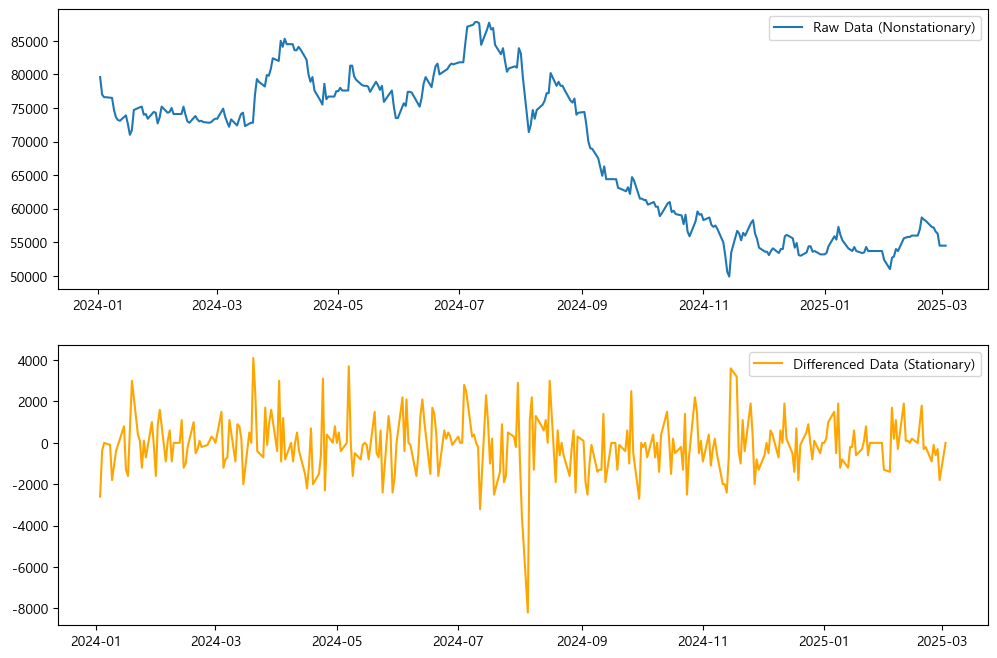

In [87]:
fig, ax=plt.subplots(2, 1, figsize=(12, 8))
ax[0].plot(company_train_data['Close'])
ax[0].legend(['Raw Data (Nonstationary)'])

ax[1].plot(company_diff_train_data, 'orange')
ax[1].legend(['Differenced Data (Stationary)'])

plt.show()

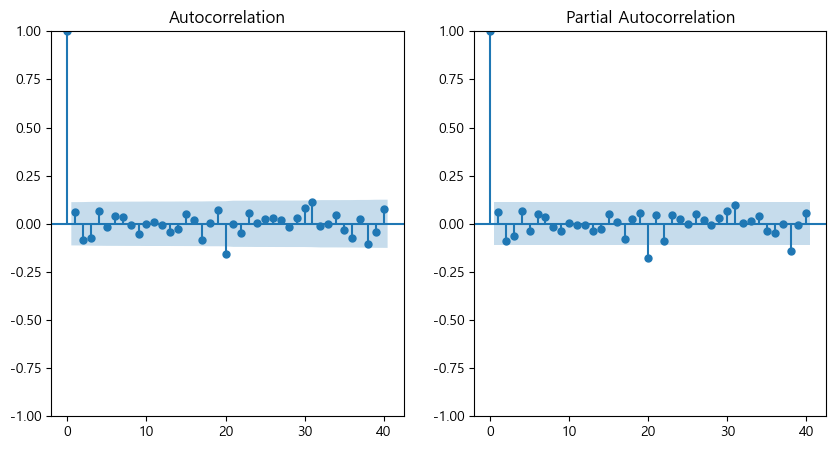

In [89]:
# ACF, PACF 플롯
fig, ax=plt.subplots(1, 2, figsize=(10, 5))
plot_acf(company_diff_train_data.values, lags=40, ax=ax[0])         # ACF 플롯
plot_pacf(company_diff_train_data.values, lags=40, ax=ax[1])        # PACF 플롯
plt.show()

## Auto_arima 모델
- from pmdarima import auto_arima
- 주식 데이터는 불규칙하므로, 계절성을 고려하지 않음

In [92]:
auto_model=auto_arima(company_train_data, 
                      start_p=1, start_q=1, max_p=3, max_q=3,
                      seasonal=False,
                      trace=True, 
                      error_action='ignore', 
                      suppress_warnings=True, 
                      stepwise=False)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5234.757, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5235.051, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5236.322, Time=0.14 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=5238.042, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5235.144, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5236.472, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5238.171, Time=0.29 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5239.686, Time=0.58 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5236.372, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5238.288, Time=0.30 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5239.806, Time=0.63 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.36 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=5238.088, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5239.699, Time=0.64 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.14 sec

Best model:  ARIMA(

In [94]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  305
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2615.378
Date:                Wed, 26 Mar 2025   AIC                           5234.757
Time:                        14:50:07   BIC                           5242.191
Sample:                    01-02-2024   HQIC                          5237.730
                         - 03-03-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -82.5658     76.541     -1.079      0.281    -232.583      67.451
sigma2      1.739e+06   7.84e+04     22.168      0.000    1.58e+06    1.89e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.23   Jarque-Bera (JB):               278.79
Prob(Q):                              0.27   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                            -0.40
Prob(H) (two-sided):                  0.29   Kurtosis:                         7.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## 예측

In [97]:
auto_pred=auto_model.predict(len(company_test_data))

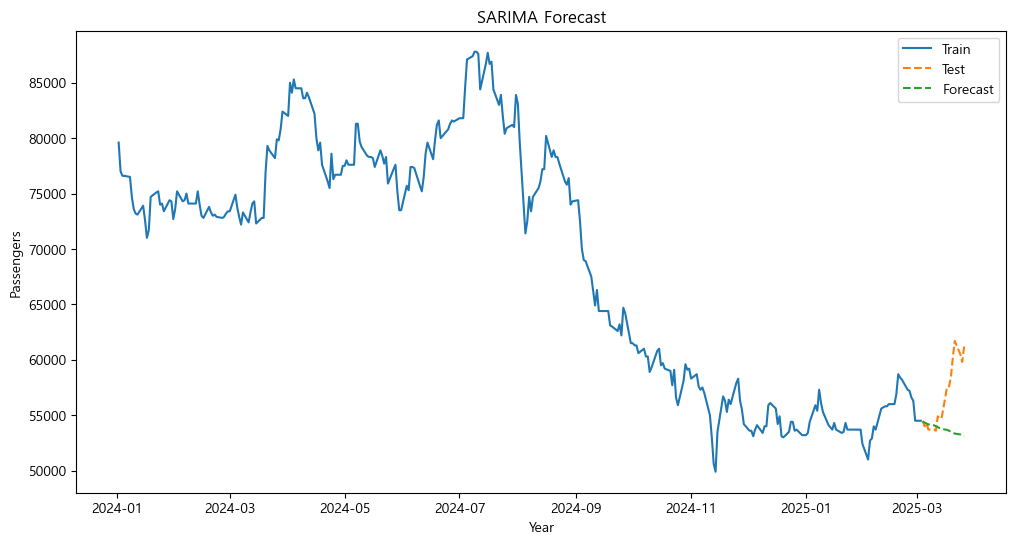

In [102]:
plt.figure(figsize=(12, 6))
plt.plot(company_train_data, label="Train")
plt.plot(company_test_data, label="Test", linestyle="dashed")
plt.plot(company_test_data.index, auto_pred, label="Forecast", linestyle="dashed")

plt.title("SARIMA Forecast")
plt.xlabel("Year")
plt.ylabel("Passengers")
plt.legend()
plt.show()

In [72]:
# 다음날 예측 (1일 예측)
next_day_pred=auto_model.predict(n_periods=16)
next_day_pred

2025-03-04    54417.434211
2025-03-05    54334.868421
2025-03-06    54252.302632
2025-03-07    54169.736842
2025-03-10    54087.171053
2025-03-11    54004.605263
2025-03-12    53922.039474
2025-03-13    53839.473684
2025-03-14    53756.907895
2025-03-17    53674.342105
2025-03-18    53591.776316
2025-03-19    53509.210526
2025-03-20    53426.644737
2025-03-21    53344.078947
2025-03-24    53261.513158
2025-03-25    53178.947368
Freq: B, dtype: float64


In [203]:
company_test_data.tail(16)

,Close
Date,
2025-03-05,54000
2025-03-06,54300
2025-03-07,53700
2025-03-10,53700
2025-03-11,53600
2025-03-12,54900
2025-03-13,54700
2025-03-14,54700
2025-03-17,57600


# 마트 상품 가격 예측
## 데이터 가져오기 및 전처리

In [111]:
mart=pd.read_csv('./Data/supervised/mart.csv')
mart.shape

(803675, 3)

In [113]:
mart.head()

,구매일,구매금액,물품대분류
0,2018-04-20,57120,기저귀
1,2018-04-20,15900,더블하트
2,2018-04-20,7000,더블하트
3,2018-04-20,20900,더블하트
4,2018-05-06,26500,더블하트


In [115]:
mart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 803675 entries, 0 to 803674
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   구매일     803675 non-null  object
 1   구매금액    803675 non-null  int64 
 2   물품대분류   803675 non-null  object
dtypes: int64(1), object(2)
memory usage: 18.4+ MB


In [117]:
mart['구매일']=pd.to_datetime(mart['구매일'])
mart.set_index('구매일', inplace=True)

In [119]:
mart.head()

,구매금액,물품대분류
구매일,,
2018-04-20,57120,기저귀
2018-04-20,15900,더블하트
2018-04-20,7000,더블하트
2018-04-20,20900,더블하트
2018-05-06,26500,더블하트


<Axes: xlabel='구매일', ylabel='구매금액'>

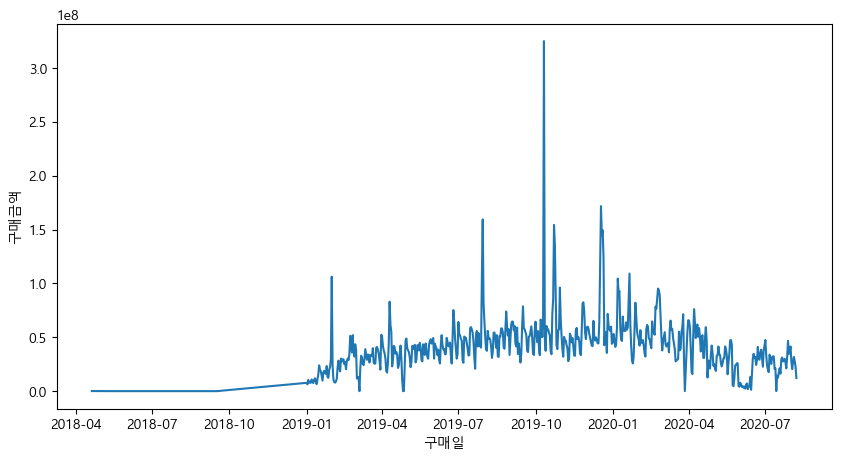

In [121]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=mart, x='구매일', y='구매금액', errorbar=None, estimator=sum)

<Axes: xlabel='구매일', ylabel='구매금액'>

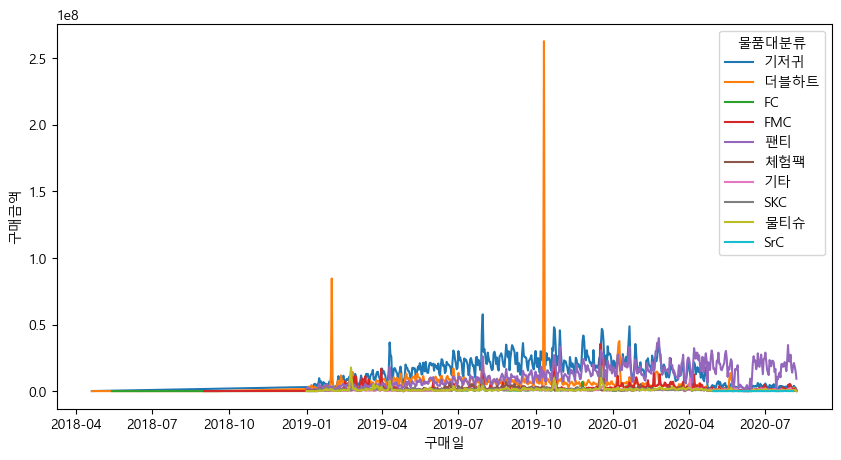

In [123]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=mart, x='구매일', y='구매금액', hue='물품대분류', errorbar=None, estimator=sum)

- 기저귀 데이터

In [154]:
cond=mart['물품대분류']=='기저귀' 
mart.loc[cond]    # 2018년 데이터는 하나밖에 없다. 

diaper=mart.loc[cond].iloc[1:]  
diaper.head()

,구매금액,물품대분류
구매일,,
2019-05-13,59520,기저귀
2019-05-10,50640,기저귀
2019-06-06,50640,기저귀
2019-07-01,50640,기저귀
2019-07-29,101280,기저귀


In [156]:
diaper.shape

(141480, 2)

## 일별 시계열 데이터 수정

In [159]:
diaper_tab=pd.pivot_table(data=diaper, 
                        index=diaper.index,
                        values='구매금액', 
                        aggfunc='sum')
diaper_tab.shape   

(578, 1)

In [161]:
diaper_tab.head()

,구매금액
구매일,
2019-01-01,3051240
2019-01-02,2556280
2019-01-03,2729480
2019-01-04,2238440
2019-01-05,2478680


In [163]:
diaper_tab.isnull().sum()

구매금액    0
dtype: int64

In [165]:
diaper_tab.shape

(578, 1)

In [167]:
diaper_tab=diaper_tab.asfreq('D', method='pad') 
diaper_tab.shape

(585, 1)

In [169]:
# diaper_tab.to_csv('./Data/supervised/mart_diaper.csv')

In [171]:
# 특정 주기 단위로 분할
# Y=diaper_tab['구매금액'].resample('1D').mean()   # 1D 한달
# Y.head()
# Y.isnull().sum()

# Y=Y.ffill()      # bfill
# Y.isnull().sum()

<Axes: xlabel='구매일'>

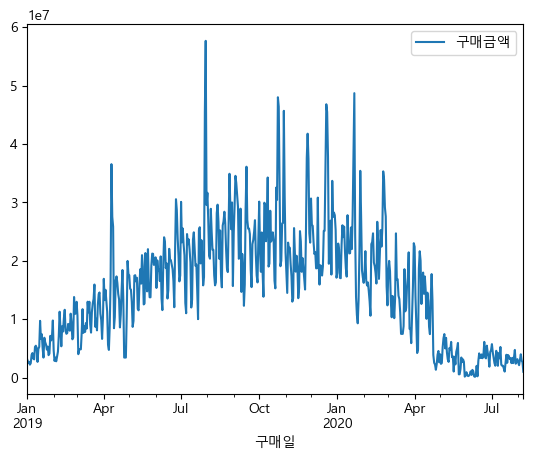

In [173]:
diaper_tab.plot()

## 시계열 분해

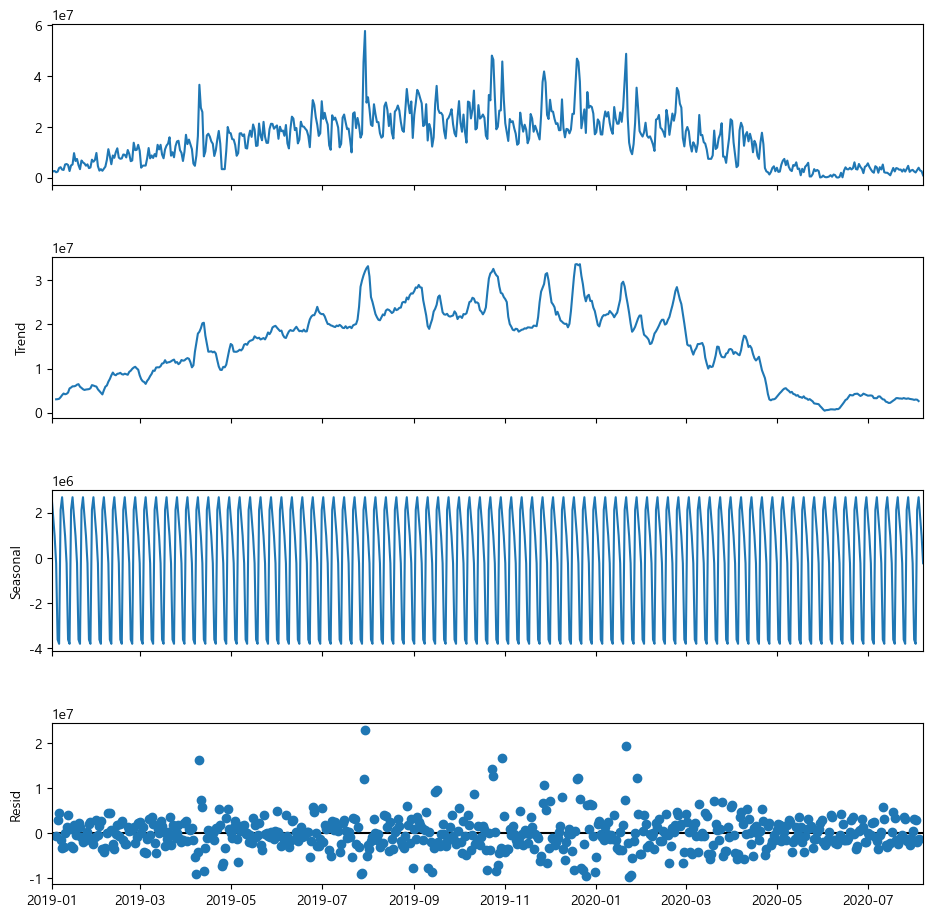

In [176]:
model_series=tsa.seasonal_decompose(diaper_tab, model='additive')  # multiplicative
fig=model_series.plot()
fig.set_size_inches(10, 10)
plt.show()

## Auto_arima 모델

In [206]:
train_data, test_data=train_test_split(diaper_tab, test_size=0.05, shuffle=False)
train_data.shape, test_data.shape

((555, 1), (30, 1))

In [208]:
auto_model=auto_arima(train_data,
                      start_p=0, start_q=0, max_p=3, max_q=3, 
                      seasonal=True, start_P=0, start_Q=0, max_P=3, max_Q=3, m=12,  
                      trace=True,                            
                      error_action='ignore',                   
                      suppress_warnings=True,                  
                      stepwise=False)                          

 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=18783.184, Time=0.15 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=18778.976, Time=0.19 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=18777.560, Time=0.46 sec
 ARIMA(0,1,0)(0,0,3)[12] intercept   : AIC=18779.560, Time=1.15 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=18780.030, Time=0.20 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=18777.693, Time=0.55 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=18779.560, Time=1.28 sec
 ARIMA(0,1,0)(1,0,3)[12] intercept   : AIC=18781.548, Time=1.73 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=18777.419, Time=0.50 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=18779.417, Time=1.43 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=3.78 sec
 ARIMA(0,1,0)(2,0,3)[12] intercept   : AIC=inf, Time=7.49 sec
 ARIMA(0,1,0)(3,0,0)[12] intercept   : AIC=18779.415, Time=1.07 sec
 ARIMA(0,1,0)(3,0,1)[12] intercept   : AIC=18781.264, Time=3.14 sec
 ARIMA(0,1,0)(3,0,2)[12] intercept   : AIC=inf, Time=11.87 s

In [213]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  555
Model:             SARIMAX(2, 1, 2)x(0, 0, [1], 12)   Log Likelihood               -9316.178
Date:                              Wed, 26 Mar 2025   AIC                          18646.355
Time:                                      16:16:30   BIC                          18676.575
Sample:                                  01-01-2019   HQIC                         18658.161
                                       - 07-08-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1414.9324   1.59e+04     -0.089      0.929   -3.26e+04    2.98e+04
ar.L1          0.9772      0.114      8.577      0.000       0.754       1.200
ar.L2         -0.4445      0.066     -6.741      0.000      -0.574      -0.315
ma.L1         -1.2459      0.121    -10.291      0.000      -1.483      -1.009
ma.L2          0.3309      0.114      2.913      0.004       0.108       0.553
ma.S.L12      -0.1100      0.041     -2.709      0.007      -0.190      -0.030
sigma2      2.279e+13      0.000    1.9e+17      0.000    2.28e+13    2.28e+13
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               348.02
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.39   Skew:                             0.91
Prob(H) (two-sided):                  0.02   Kurtosis:                         6.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.09e+32. Standard errors may be unstable.
"""

In [217]:
auto_pred=auto_model.predict(len(test_data))s

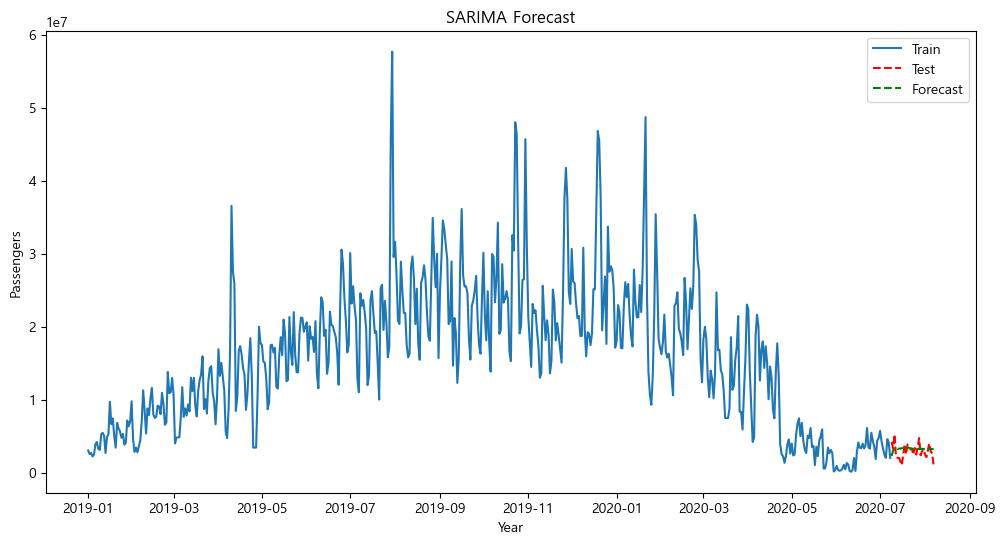

In [223]:
plt.figure(figsize=(12, 6))
plt.plot(train_data, label="Train")
plt.plot(test_data, label="Test", linestyle="dashed", color='red')
plt.plot(test_data.index, auto_pred, label="Forecast", linestyle="dashed", color='green')

plt.title("SARIMA Forecast")
plt.xlabel("Year")
plt.ylabel("Passengers")
plt.legend()
plt.show()

In [225]:
next_day_pred=auto_model.predict(n_periods=15)
next_day_pred.astype(int)

2020-07-09    2311641
2020-07-10    3052338
2020-07-11    3240995
2020-07-12    3393284
2020-07-13    3258201
2020-07-14    3315501
2020-07-15    3323613
2020-07-16    3343487
2020-07-17    3418216
2020-07-18    3151904
2020-07-19    3188050
2020-07-20    3443201
2020-07-21    3417289
2020-07-22    3348741
2020-07-23    3291860
Freq: D, dtype: int32

In [227]:
test_data.tail(15)

,구매금액
구매일,
2020-07-24,2497000
2020-07-25,3399400
2020-07-26,2503100
2020-07-27,3518800
2020-07-28,4755900
2020-07-29,2398300
2020-07-30,2957200
2020-07-31,3172000
2020-08-01,2560300
